In [1]:
# import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Fetch california housing dataset
housing = fetch_california_housing()
X = housing['data']
y = housing['target']

X = X[:1000]
y = y[:1000]

X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(np.expand_dims(y, -1))

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42)


X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

In [3]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        #self.linear = nn.Linear(input_dim, output_dim)
        self.blinear1 = BayesianLinear(input_dim, 64)
        self.blinear2 = BayesianLinear(64, output_dim)
        
    def forward(self, x):
        x_ = self.blinear1(x)
        x_ = F.relu(x_)
        return self.blinear2(x_)


def evaluate_regression(regressor,
                        X,
                        y,
                        samples = 100,
                        std_multiplier = 2):
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    ic_acc = (ci_lower <= y) * (ci_upper >= y)
    ic_acc = ic_acc.float().mean()
    return ic_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = BayesianRegressor(8, 1).to(device)
optimizer = optim.Adam(regressor.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)
criterion = torch.nn.MSELoss()

ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=64, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=64, shuffle=True)

<h1>I carefully check the code and finally find out why the loss in blitz always look like in great fluctuation and seems never converge while the loss sample function output each elbo loss for once a batch.


In [4]:
def sample_elbo_detailed_loss(self,
                    inputs,
                    labels,
                    criterion,
                    sample_nbr,
                    complexity_cost_weight=1):

        """ Samples the ELBO Loss for a batch of data, consisting of inputs and corresponding-by-index labels.
            This version of the function returns the performance part and complexity part of the loss individually
            as well as an array of predictions

                The ELBO Loss consists of the sum of the KL Divergence of the model 
                 (explained above, interpreted as a "complexity part" of the loss)
                 with the actual criterion - (loss function) of optimization of our model
                 (the performance part of the loss).

                As we are using variational inference, it takes several (quantified by the parameter sample_nbr) Monte-Carlo
                 samples of the weights in order to gather a better approximation for the loss.

            Parameters:
                inputs: torch.tensor -> the input data to the model
                labels: torch.tensor -> label data for the performance-part of the loss calculation
                        The shape of the labels must match the label-parameter shape of the criterion (one hot encoded or as index, if needed)
                criterion: torch.nn.Module, custom criterion (loss) function, torch.nn.functional function -> criterion to gather
                            the performance cost for the model
                sample_nbr: int -> The number of times of the weight-sampling and predictions done in our Monte-Carlo approach to 
                            gather the loss to be .backwarded in the optimization of the model.
        """

        loss = 0
        likelihood_cost = 0
        complexity_cost = 0
        # Array to collect the outputs
        y_hat = []
        for _ in range(sample_nbr):
            outputs = self(inputs)
            y_hat.append(outputs.cpu().detach().numpy())
            likelihood_cost += criterion(outputs, labels)
            complexity_cost += self.nn_kl_divergence() * complexity_cost_weight
        return np.array(y_hat), (likelihood_cost + complexity_cost) / sample_nbr,\
               likelihood_cost / sample_nbr,\
               complexity_cost / sample_nbr

<h1>In this case I revise the output function to calculate full elbo loss for each epoch and output every 100 epoches, since now it looks great. 

In [5]:
epochs_per_eval = 100  # Evaluate full dataset ELBO every 100 epochs
train_losses = []

for epoch in range(500):
    # Per-batch training as before
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        batch_loss = regressor.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=2,
                           complexity_cost_weight=1/X_train.shape[0])
        batch_loss.backward()
        optimizer.step()
        
    
    # Calculate full dataset ELBO every epoch (for scheduler)
    regressor.eval()
    with torch.no_grad():
        # Compute ELBO on full training set
        full_train_loss = 0
        for train_batch, train_labels in dataloader_train:
            batch_loss = regressor.sample_elbo(
                inputs=train_batch.to(device),
                labels=train_labels.to(device),
                criterion=criterion,
                sample_nbr=10,
                complexity_cost_weight=1/X_train.shape[0]
            )
            full_train_loss += batch_loss.item() * train_batch.size(0)
        full_train_loss /= len(X_train)
        train_losses.append(full_train_loss)
        # Step the scheduler with the full training loss
        # scheduler.step(full_train_loss)
        
        # Print detailed metrics only every epochs_per_eval epochs
        if epoch % epochs_per_eval == epochs_per_eval - 1:
            # Evaluate performance metrics on test set
            ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(
                regressor,
                X_test.to(device),
                y_test.to(device),
                samples=25,
                std_multiplier=3
            )
            print(f"Epoch {epoch+1}/{500}")
            print(f"Full Train ELBO Loss: {full_train_loss:.4f}")
            print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
            print(f"CI acc: {ic_acc:.2f}, CI upper acc: {under_ci_upper:.2f}, CI lower acc: {over_ci_lower:.2f}")
    
    regressor.train()

Epoch 100/500
Full Train ELBO Loss: 3.5551
Current LR: 0.001000
CI acc: 0.02, CI upper acc: 0.67, CI lower acc: 0.35
Epoch 200/500
Full Train ELBO Loss: 3.0444
Current LR: 0.001000
CI acc: 0.04, CI upper acc: 0.70, CI lower acc: 0.34
Epoch 300/500
Full Train ELBO Loss: 2.5364
Current LR: 0.001000
CI acc: 0.08, CI upper acc: 0.70, CI lower acc: 0.38
Epoch 400/500
Full Train ELBO Loss: 2.0315
Current LR: 0.001000
CI acc: 0.10, CI upper acc: 0.70, CI lower acc: 0.40
Epoch 500/500
Full Train ELBO Loss: 1.5522
Current LR: 0.001000
CI acc: 0.22, CI upper acc: 0.76, CI lower acc: 0.46


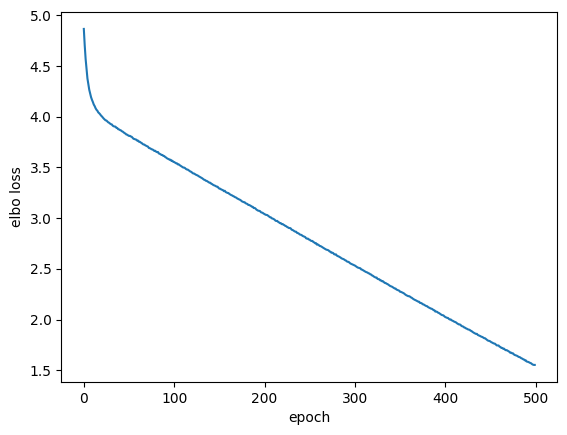

In [6]:
# Plot the training loss
plt.plot(train_losses)
plt.xlabel('epoch')
plt.ylabel('elbo loss')
plt.show()

In [7]:
# Generate predictions with the model
regressor.eval()
with torch.no_grad():
    # Get predictions with uncertainty
    num_samples = 50
    predictions = []
    for _ in range(num_samples):
        pred = regressor(X_test.to(device))
        predictions.append(pred.cpu().numpy())
    
    # Convert predictions to numpy arrays
    predictions = np.array(predictions).squeeze()
    
    # Calculate mean and std of predictions
    pred_mean = predictions.mean(axis=0)
    pred_std = predictions.std(axis=0)
    
    # Calculate confidence intervals
    ci_upper = pred_mean + 2 * pred_std
    ci_lower = pred_mean - 2 * pred_std

# Convert to numpy for plotting
y_test_np = y_test.cpu().numpy().squeeze()

# Sort by true values for clearer visualization
sort_indices = np.argsort(y_test_np)
y_test_sorted = y_test_np[sort_indices]
pred_mean_sorted = pred_mean[sort_indices]
ci_upper_sorted = ci_upper[sort_indices]
ci_lower_sorted = ci_lower[sort_indices]

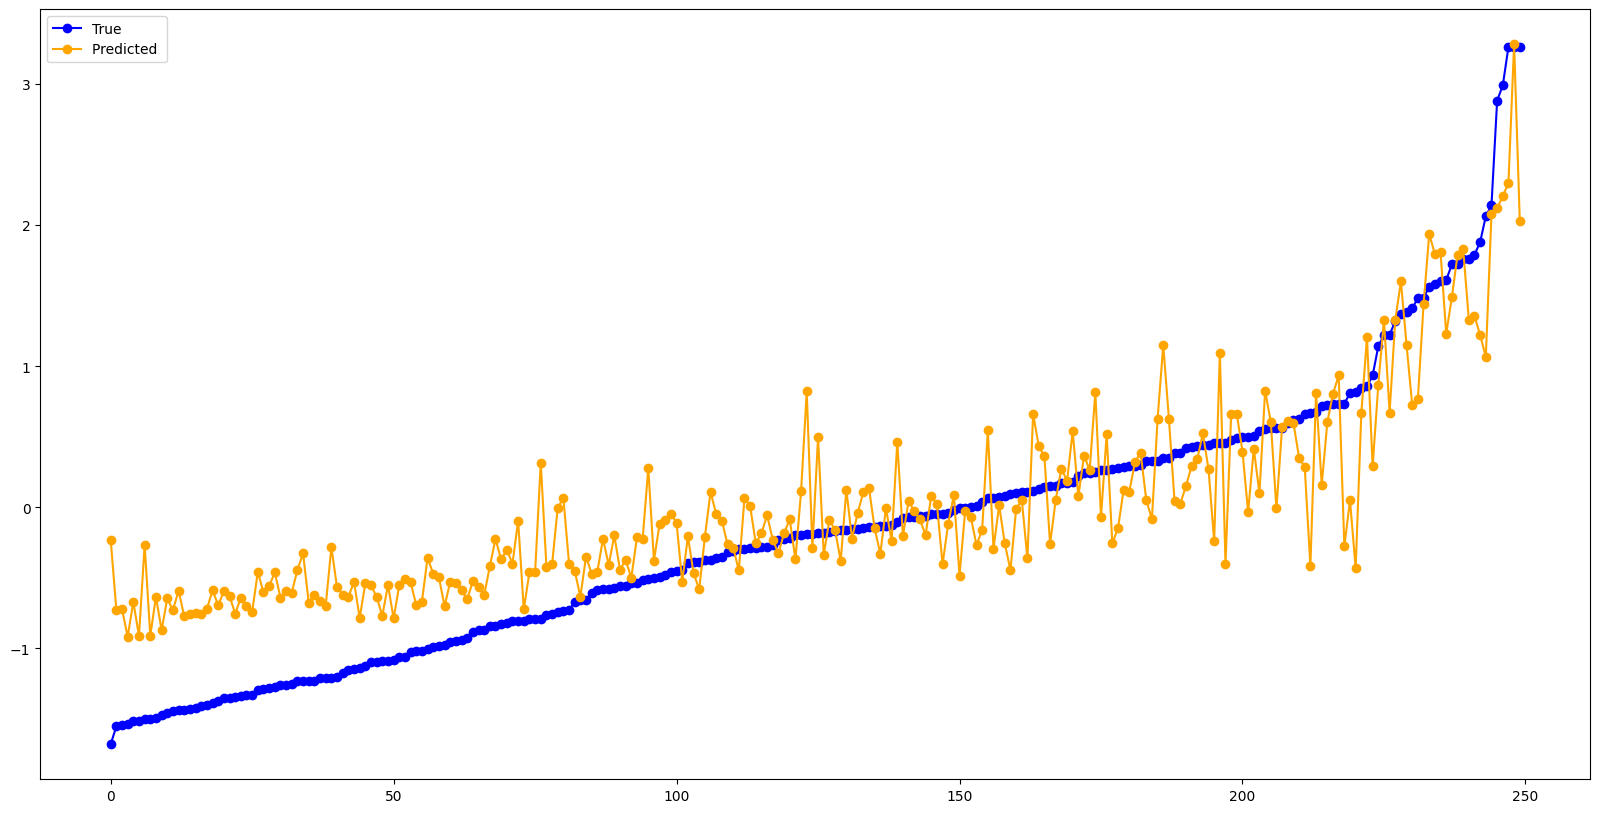

In [8]:
plt.figure(figsize=(20,10))
plt.plot(y_test_sorted,'o-', label=f'True ', color='blue')
plt.plot(pred_mean_sorted,'o-', label=f'Predicted ', color='orange')
plt.legend()

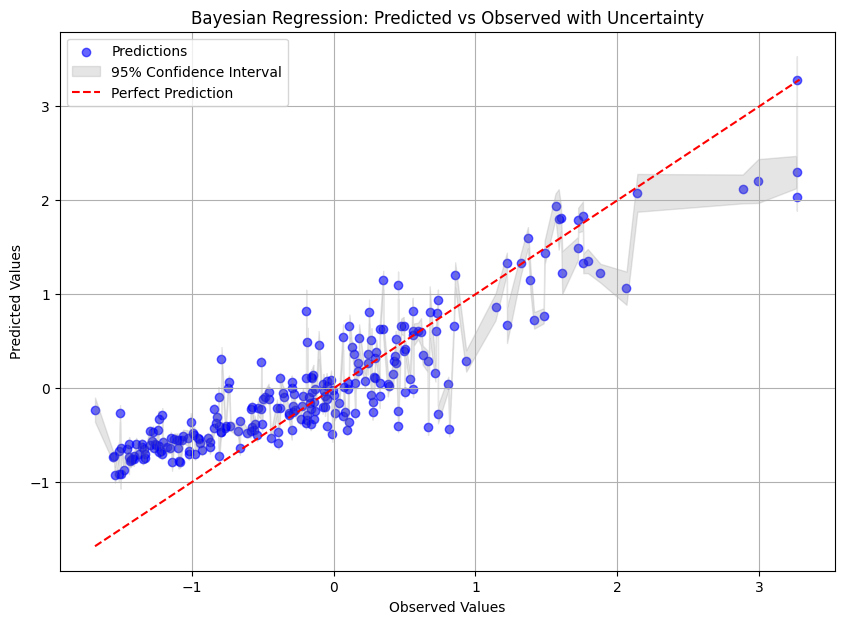

In [9]:
plt.figure(figsize=(10, 7))

# Plot the predictions vs true values
plt.scatter(y_test_sorted, pred_mean_sorted, alpha=0.6, label='Predictions', color='blue')

# Plot the confidence intervals
plt.fill_between(y_test_sorted, ci_lower_sorted, ci_upper_sorted, 
                alpha=0.2, color='gray', label='95% Confidence Interval')

# Add the perfect prediction line (y=x)
min_val = min(y_test_np.min(), pred_mean.min())
max_val = max(y_test_np.max(), pred_mean.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

# Add labels and legend
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Bayesian Regression: Predicted vs Observed with Uncertainty')
plt.legend()
plt.grid(True)
plt.show()